In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# **Our mission**

In order to provide meaningful analysis of LendingClub's customers, we first need to understand a little bit about the business and several key questions. LendingClub is a peer-to-peer loan provider, meaning they allow people to apply for loans, and other individuals or companies to furfil those loans. LendingClub itself needs not finance any loans with their own money, but has a responsability to its customers to verify that those who are applying for loans have the ability to pay in a timely manner. You can therefor think of LendingClub's role in these transactions as a credit auditor.

The core queston for LendingClub becomes "Who can repay their loans?". To support this question, we first ask severl other questions:

    Who is getting loans?
    What kind of loans are being given out?
    How accurate is LendingClubs loan grading system?
    What data points are important in determining if someone will repay?

After answering these questions, we explore making accurate machine learning algorithims and attempt to answer our core question.



# **Data processing**

The first step to understanding our data is to clean up our data and identify columns that are important or not important.


In [13]:
# Import basic data science packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import map visulization libraries
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

In [14]:
path = "/content/drive/MyDrive/CSV FILES/accepted_2007_to_2018Q4.csv"
df = pd.read_csv(path)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,227000.0,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,907xx,CA,12.75,7.0,Feb-1995,705.0,709.0,1.0,9.0,NaN,5.0,0.0,8633.0,64.9,37.0,f,23252.59,23252.59,...,55970.0,28398.0,12300.0,42670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,110000.0,Not Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,334xx,FL,18.30,0.0,Jul-1999,660.0,664.0,0.0,67.0,72.0,10.0,1.0,17641.0,68.1,31.0,f,0.00,0.00,...,84664.0,62426.0,20700.0,58764.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,Customer Service Technician,10+ years,MORTGAGE,95000.0,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,770xx,TX,23.36,0.0,Jun-1996,660.0,664.0,1.0,37.0,NaN,8.0,0.0,7662.0,54.0,22.0,w,8456.12,8456.12,...,163804.0,44215.0,9500.0,34169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260700,Total amount funded in policy code 2: 521953170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(2260701, 151)

In [ ]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,...,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,1.207100e+05,120706.000000,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,...,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,5.768354e-01,3.454092e+01,72.312842,1.161240e+01,1.975278e-01,1.665846e+04,5.033770e+01,2.416255e+01,4.206891e+03,4.205965e+03,1.208256e+04,1.206439e+04,9.505772e+03,2.431388e+03,1.518453e+00,1.438791e+02,2.398257e+01,3.429346e+03,6.876610e+02,6.755397e+02,1.814580e-02,44.164220,1.0,1.236246e+05,19.251817,4.147942e-03,2.327317e+02,1.424922e+05,9.344199e-01,...,7.726402e+00,8.413439e+00,8.246523e+00,1.400463e+01,5.577951e+00,1.162813e+01,6.373958e-04,2.813652e-03,8.293767e-02,2.076755e+00,9.411458e+01,4.243513e+01,1.281935e-01,4.677109e-02,1.782428e+05,5.102294e+04,2.319377e+04,4.373201e+04,3.361728e+04,669.755603,673.755631,0.633256,1.538997,11.469455,58.169101,3.010554,12.533072,0.046352,0.077568,36.937928,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,NaN,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,3.301124e+01,8.859632e-01,2.190047e+01,26.464094,5.640861e+00,5.705150e-01,2.294831e+04,2.471307e+01,1.198753e+01,7.343239e+03,7.342333e+03,9.901383e+03,9.896992e+03,8.321852e+03,2.679738e+03,1.184159e+01,7.481640e+02,1.312256e+02,6.018248e+03,7.297044e+01,1.110976e+02,1.508131e-01,21.533121,0.0,7.416135e+04,7.822086,6.961656e-02,8.518462e+03,1.606926e+05,1.140700e+00,...,4.701430e+00,7.359114e+00,4.683928e+00,8.038868e+00,3.293434e+00,5.644027e+00,2.710643e-02,5.616522e-02,4.935732e-01,1.830711e+00,9.036140e+0



# **Data Cleaning**

We've identified several columns that fit into one of the following categories:

    Unneccesary data such as the URL to view the loan
    Redundant data. Loan description may be useful to some, but the much more conciese loan purpose fits our needs
    User provided information. Employer titles may offer some insight into employment industry, but would need significant cleanup to provide useful statistics
    Operational data. The next payment date for the loan at the time the data was generated is not relevant to us



In [15]:
# Drop unneccesary columns
df = df.drop(['url', 'desc', 'policy_code', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'emp_title'], axis=1)
df = df.drop(['id', 'title', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'zip_code'], axis=1)
df = df.drop(['revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util'], axis=1)
df = df.drop(['sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog'], axis=1)
df = df.drop(['hardship_flag','hardship_type','hardship_reason','hardship_status', 	'deferral_term','hardship_amount','hardship_start_date'], axis=1)
df = df.drop(['hardship_end_date','payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status','orig_projected_additional_accrued_interest'], axis=1)
df = df.drop(['hardship_payoff_balance_amount', 'hardship_last_payment_amount'], axis=1)
df = df.drop(['debt_settlement_flag_date', 	'settlement_status', 	'settlement_date', 	'settlement_amount', 	'settlement_percentage', 	'settlement_term','member_id'], axis=1)



In [16]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,...,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,5.91,0.0,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,0.0,0.0,122.67,Mar-2019,564.0,560.0,...,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,16.06,1.0,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,0.0,0.0,926.35,Mar-2019,699.0,695.0,...,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash,N
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,IL,10.78,0.0,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,0.0,0.0,15813.30,Mar-2019,704.0,700.0,...,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,NJ,17.06,0.0,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,0.0,0.0,829.90,Mar-2019,679.0,675.0,...,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,Cash,N
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,25.37,1.0,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,0.0,0.0,10128.96,Mar-2018,704.0,700.0,...,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash,N


Additionally, we identified some rows that we decided were not relevant to our needs. The 'loan_status' column is the source of our answer to the core question if people are paying the loans they take out. We found some records with a loan_status of "Does not meet the credit policy". We believe these may be older loans that would simply not be accepted under LendingClubs current criteria. As these data points will provide no value moving forward, we've ecluded them from our data. Similiarily, recently issued loans could mislead our analysis, as no payment has been expected yet.

In [17]:
#Checking the overall percent of null values
missing=df.isnull().sum()
total_cells=np.product(df.shape)
total_missing=missing.sum()

percent_missing=(total_missing/total_cells)*100
print(percent_missing)

12.727269752307219


In [ ]:
i = len(df)
df = pd.DataFrame(df[df['loan_status'] != "Does not meet the credit policy. Status:Fully Paid"])
df = pd.DataFrame(df[df['loan_status'] != "Does not meet the credit policy. Status:Charged Off"])
df = pd.DataFrame(df[df['loan_status'] != "Issued"])
df = pd.DataFrame(df[df['loan_status'] != "In Grace Period"])
a = len(df)
print(f"We dropped {i-a} rows, a {((i-a)/((a+i)/2))*100}% reduction in rows")

We dropped 11185 rows, a 0.49598500471263357% reduction in rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2249516 entries, 0 to 2260700
Columns: 138 entries, member_id to settlement_term
dtypes: float64(109), object(29)
memory usage: 2.3+ GB




A significant amount of data remains, and we will move forward with the following columns remaining



# **Analysis**

We first begin to look at our data to better understand our demographics. We start by taking a look at the length of employment for our customers.



In [ ]:
# make temporary dataframe in order to keep original dataframe
df_copy = df.copy()
df_copy["emp_length"] = ["0.5" if x == '< 1 year' else x for x in df_copy["emp_length"]]

# check employment length
df_copy.emp_length.unique()

array(['10+ years', '3 years', '4 years', '6 years', '1 year', '7 years',
       '8 years', '5 years', '2 years', '9 years', '0.5', nan],
      dtype=object)

We will start by exploring the distribution of the loan amounts and see when did the loan amount issued increased significantly.

What we need to know:

    Understand what amount was mostly issued to borrowers.
    Which year issued the most loans.
    The distribution of loan amounts is a multinomial distribution .

Summary:

    Most of the loans issued were in the range of 10,000 to 20,000 USD.
    The year of 2015 was the year were most loans were issued.
    Loans were issued in an incremental manner. (Possible due to a recovery in the U.S economy)
    The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for.


Text(0.5, 1.0, 'Total committed by Investors')

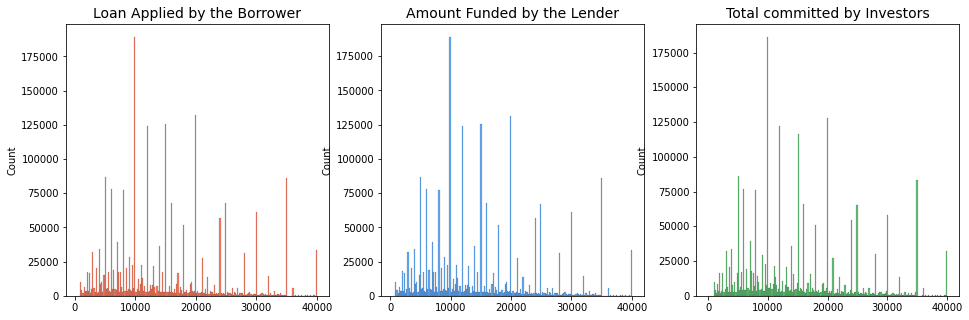

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))




loan_amnt = df["loan_amnt"].values
funded_amnt = df["funded_amnt"].values
funded_amnt_inv = df["funded_amnt_inv"].values


sns.histplot(loan_amnt, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.histplot(funded_amnt, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.histplot(funded_amnt_inv, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

In [ ]:
# Lets' transform the issue dates by year.
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Average loan amount issued')

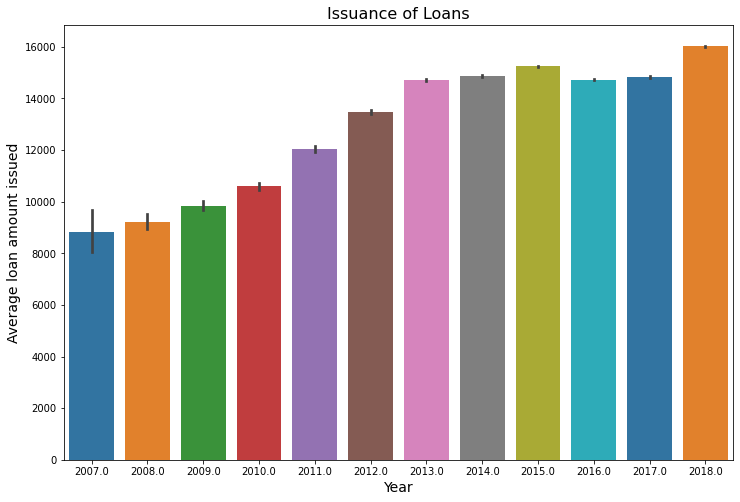

In [ ]:
# The year of 2018 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

# **Good Loans vs Bad Loans:**

In this section, we will see what is the amount of bad loans Lending Club has declared so far, of course we have to understand that there are still loans that are at a risk of defaulting in the future.

What we need to know:

    The amount of bad loans could increment as the days pass by, since we still have a great amount of current loans.
    Average annual income is an important key metric for finding possible opportunities of investments in a specific region.

Summary:

    Currently, bad loans consist 7.60% of total loans but remember that we still have current loans which have the risk of becoming bad loans. (So this percentage is subjected to possible changes.)
    The NorthEast region seems to be the most attractive in term of funding loans to borrowers.
    The SouthWest and West regions have experienced a slight increase in the "median income" in the past years.
    Average interest rates have declined since 2012 but this might explain the increase in the volume of loans.
    Employment Length tends to be greater in the regions of the SouthWest and West
    Clients located in the regions of NorthEast and MidWest have not experienced a drastic increase in debt-to-income(dti) as compared to the other regions.


In [ ]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [ ]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

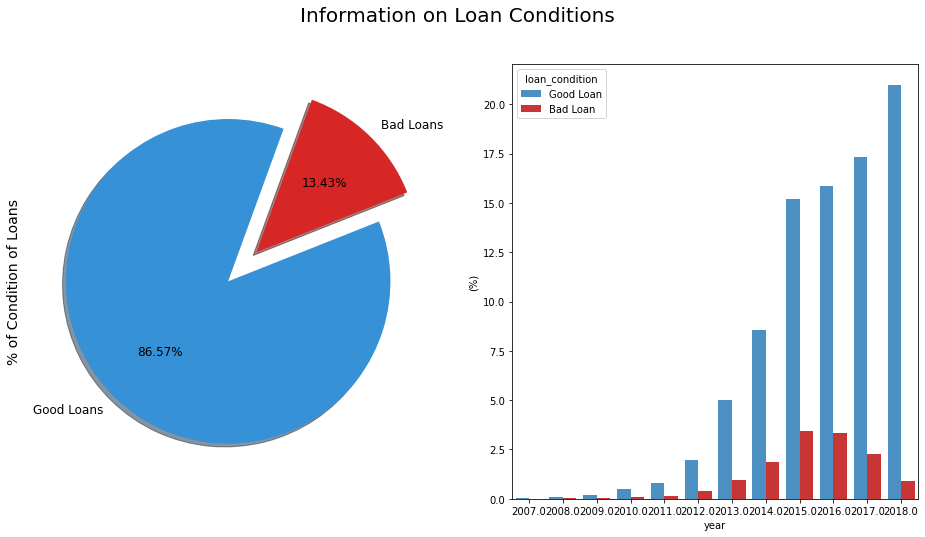

In [ ]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amnt", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

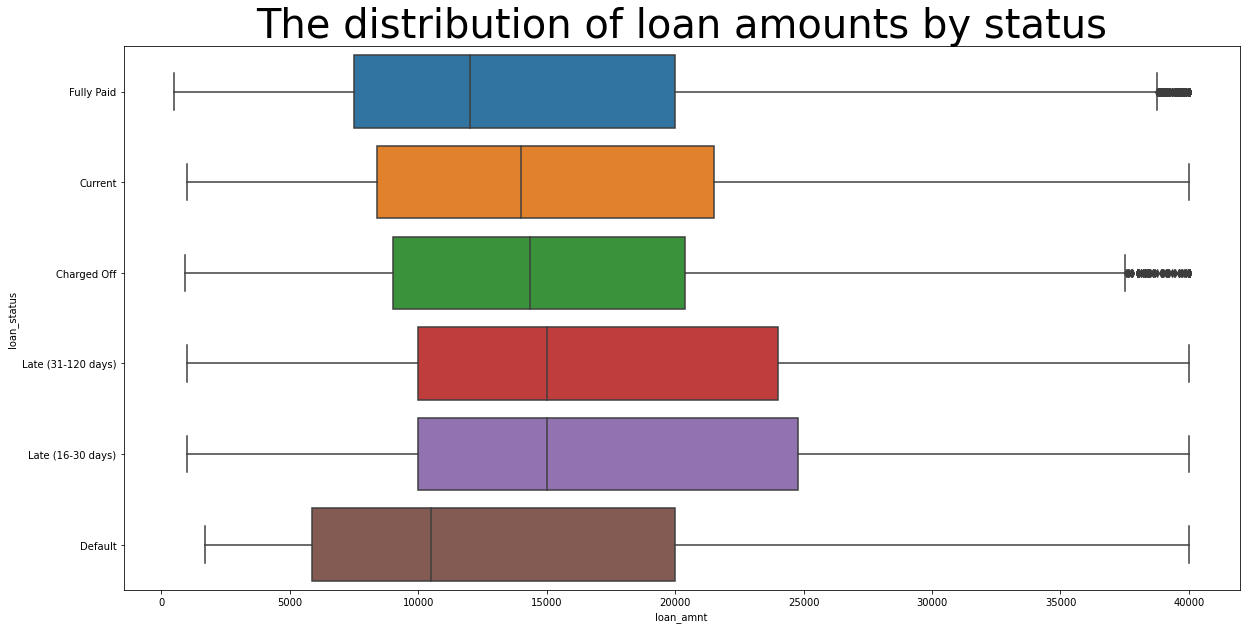

In [ ]:
# Loan amount by its status
plt.subplots(figsize=(20,10))
plt.title("The distribution of loan amounts by status").set_size(40)
sns.boxplot(x="loan_amnt", y="loan_status", data=df_copy)


Summary

    Fully Paid loans tend to be smaller. This could be due to the age of the loans
    Default has the highest count among other loan status.
    In Grace Period and Late(16~30 days) have the highest loan amount and mean.



# **Loan Amount Base on Grade**

The next question we wanted to answer was "What kind of loans are being issued?". We decided to approach this by the grade that LendingClub assigns to the loan. The Grade is a value from A to G that is a culmination of LendingClubs own analysis on the ability for the customer to repay the grade.


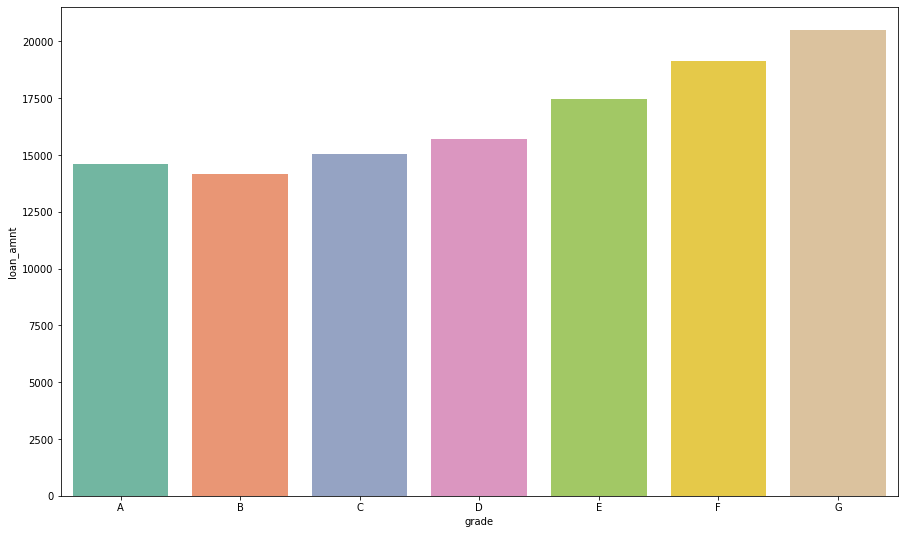

In [ ]:
group = df_copy.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2')

In [ ]:
# clean plot
plt.clf()

<Figure size 432x288 with 0 Axes>


Summary

    The lower grade, the higher loan amount loan issued


# **Interest Rate base on Grade**

We also wanted to look at the distribution of interst rate that loans are given, based on their LendingClub assigned grade.

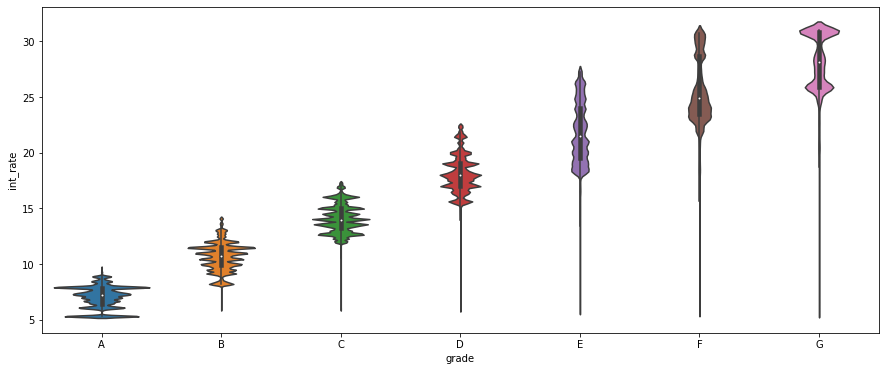

In [ ]:
plt.subplots(figsize=(15,6))
sns.violinplot(x="grade", y="int_rate", data=df_copy, order="ABCDEFG")


Summary

    Interest rate varies wildly, reaching nearly 30% for high-risk loans
    Grade A has the lowest interest rate around 7%
    Grade G has the highest interest rate above 25%


# **Loan status by grade**

We were also curious how accurate LendingClub's Grades were. This is a look into what percentage of loans are current or already paid off by grade.

In [ ]:
print("% of loans that are current or fully paid by grade")
print(f"A: {round((103322+39679)/(2617+103322+47+39679+365+134+492) * 100, 2)}%")
print(f"B: {round((171735+66546)/(9519+171735+198+66546+1240+410+2004) * 100, 2)}%")
print(f"C: {round((171175+52678)/(12642+171175+360+52678+1887+678+3339) * 100, 2)}%")
print(f"D: {round((91984+30020)/(10486+91984+312+30020+1405+369+2890) * 100, 2)}%")
print(f"E: {round((47061+12928)/(6258+47061+201+12928+908+368+1852) * 100, 2)}%")
print(f"F: {round((13589+4726)/(2934+13589+79+4726+354+155+768)* 100, 2)}%")
print(f"G: {round((2913+1146)/(792+2913+22+1146+94+42+246)* 100, 2)}%")
pd.pivot_table(df, index="loan_status", columns="grade", aggfunc="size")

% of loans that are current or fully paid by grade
A: 97.51%
B: 94.69%
C: 92.21%
D: 88.75%
E: 86.22%
F: 81.02%
G: 77.24%


grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,14201.0,52569.0,85649.0,61054.0,36035.0,14491.0,4560.0
Current,195539.0,262903.0,255707.0,115138.0,38080.0,8485.0,2465.0
Default,5.0,7.0,8.0,13.0,6.0,1.0,NaN
Fully Paid,220889.0,340172.0,296037.0,139899.0,57615.0,17567.0,4572.0
Late (16-30 days),341.0,993.0,1476.0,969.0,402.0,129.0,39.0
Late (31-120 days),1322.0,4788.0,7554.0,4761.0,2166.0,640.0,236.0


# **Loans Issued by Region**
In this section we want to analyze loans issued by region in order to see region patters that will allow us to understand which region gives Lending Club.

Summary:

    SouthEast , West and NorthEast regions had the highest amount lof loans issued.
    West and SouthWest had a rapid increase in debt-to-income starting in 2012.
    West and SouthWest had a rapid decrease in interest rates (This might explain the increase in debt to income).


In [ ]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)

In [ ]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amnt'] = group_dates['loan_amnt']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amnt']])

Text(0.5, 1.0, 'Loans issued by Region')

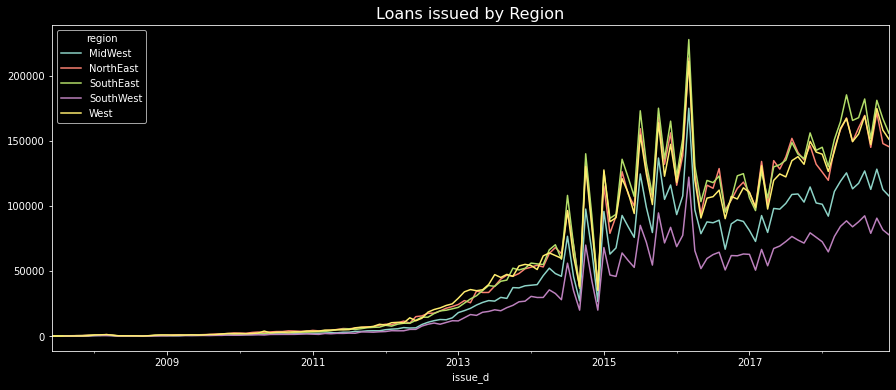

In [ ]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amnt.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

In [ ]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

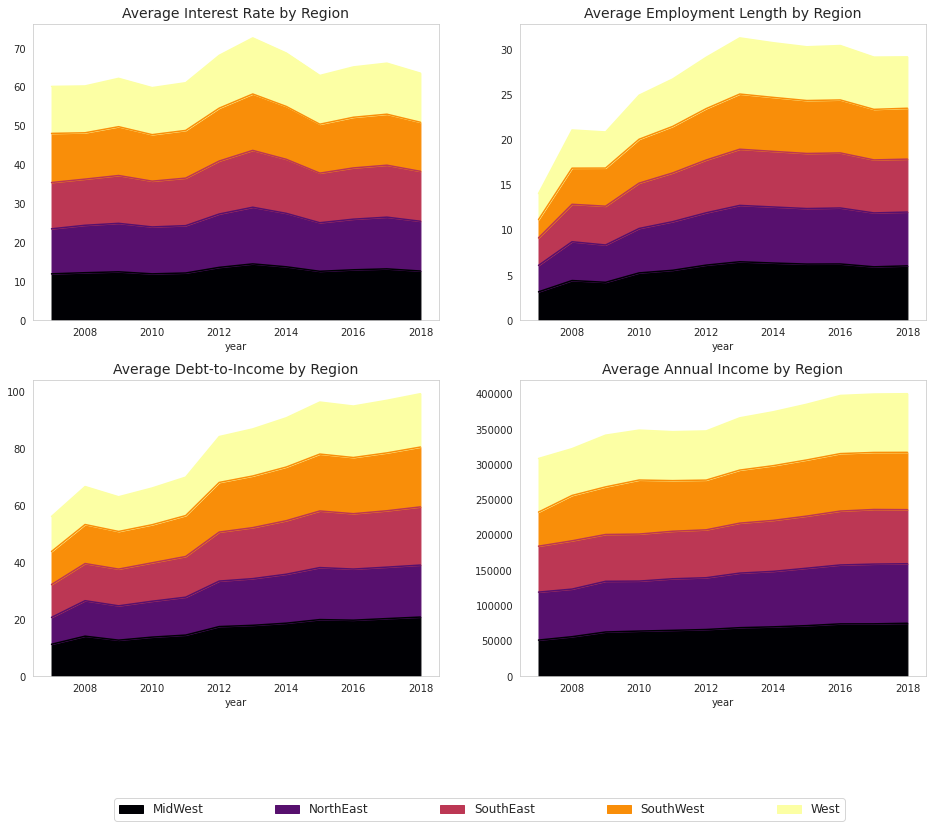

In [ ]:
# Loan issued by Region and by Credit Score grade
# Change the colormap for tomorrow!

sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['year', 'region']).int_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['year', 'region']).annual_inc.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)


# **A Deeper Look into Bad Loans:**

What we need to know:

    The number of loans that were classified as bad loans for each region by its loan status. (This will be shown in a dataframe below.)
    This won't give us the exact reasons why a loan is categorized as a bad loan (other variables that might have influence the condition of the loan) but it will give us a deeper insight on the level of risk in a particular region.

Summary:

    The regions of the West and SouthEast had a higher percentage in most of the b "bad" loan statuses.
    The NorthEast region had a higher percentage in Grace Period and Does not meet Credit Policy loan status. However, both of these are not considered as bad as default for instance.
    Based on this small and brief summary we can conclude that the West and SouthEast regions have the most undesirable loan status, but just by a slightly higher percentage compared to the NorthEast region.
    Again, this does not tell us what causes a loan to be a bad loan , but it gives us some idea about the level of risk within the regions across the United States.



In [ ]:
# We have 67429 loans categorized as bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,46377,7,142,1405,649,3476,52056
NorthEast,62535,13,190,2228,1110,5181,71257
SouthEast,67229,7,184,2164,1138,5549,76271
SouthWest,32712,6,79,964,515,2671,36947
West,59706,7,166,1675,937,4590,67081


# **The Business Perspective **

### Understanding the Operative Side of Business 

Now we will have a closer look at the operative side of business by state. This will give us a clearer idea in which state we have a higher operating activity. This will allow us to ask further questions such as Why do we have a higher level of operating activity in this state? Could it be because of economic factors? or the risk level is low and returns are fairly decent? Let's explore!

What we need to know:

    We will focus on three key metrics: Loans issued by state (Total Sum), Average interest rates charged to customers and average annual income of all customers by state.
    The purpose of this analysis is to see states that give high returns at a descent risk.

Summary:

    California, Texas, New York and Florida are the states in which the highest amount of loans were issued.
    Interesting enough, all four states have a approximate interest rate of 13% which is at the same level of the average interest rate for all states (13.24%)
    California, Texas and New York are all above the average annual income (with the exclusion of Florida), this might give possible indication why most loans are issued in these states.


In [ ]:
# Plotting by states

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amnt.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).int_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_inc.mean()



# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()
average_annual_income = by_income['annual_inc'].values.tolist()


from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('int_rate', average_interest_rates),
                            ('annual_inc', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()



# Think of a way to add default rate
# Consider adding a few more metrics for the future

,state_codes,issued_loans,int_rate,annual_inc
0,IA,1.140750e+05,12.63,44756.21
1,IL,1.410452e+09,12.96,79884.92
2,IN,5.507767e+08,13.18,70365.19
3,KS,2.838778e+08,13.00,71456.55
4,MI,8.416461e+08,13.16,71660.97


# **The Importance of Credit Scores:**

Credit scores are important metrics for assesing the overall level of risk. In this section we will analyze the level of risk as a whole and how many loans were bad loans by the type of grade received in the credit score of the customer.

What we need to know:

    The lower the grade of the credit score, the higher the risk for investors.
    There are different factors that influence on the level of risk of the loan.

Summary:

    The scores that has a lower grade received a larger amounts of loans (which might had contributed to a higher level of risk).

    Logically, the lower the grade the higher the interest the customer had to pay back to investors.

    Interstingly, customers with a grade of "C" were more likely to default on the loan 

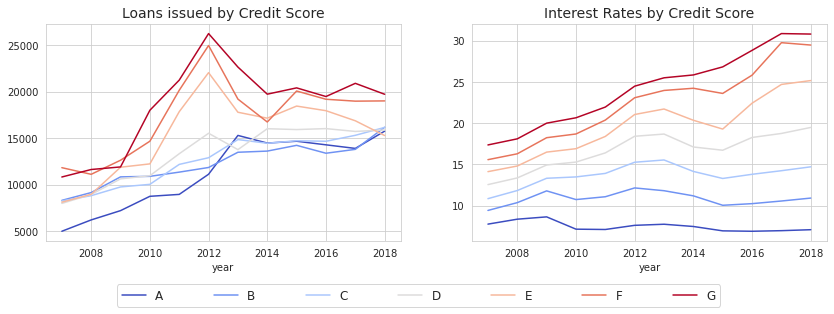

In [ ]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

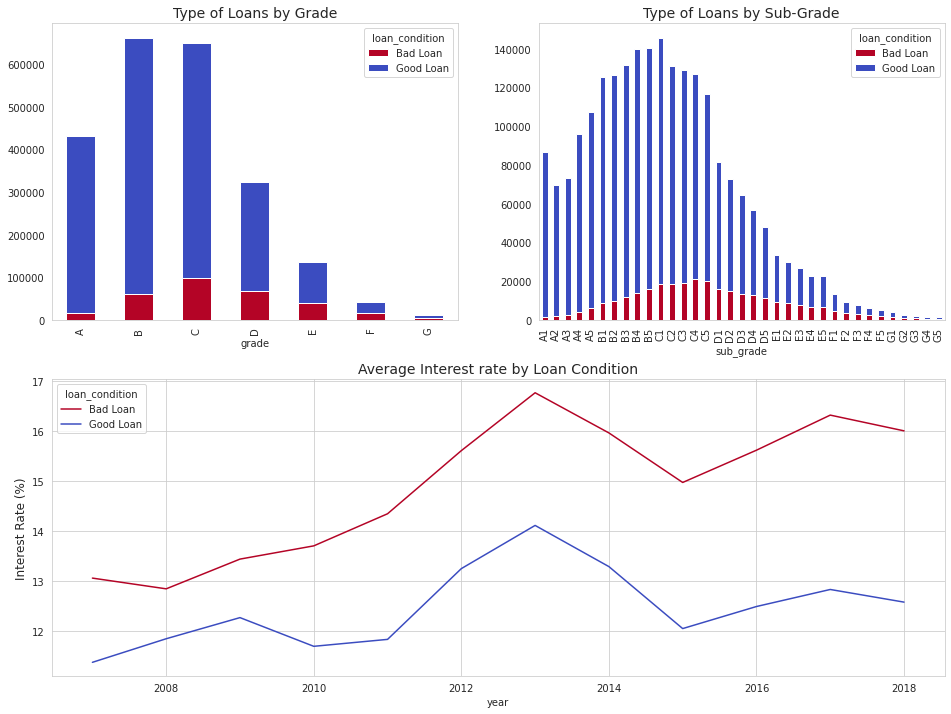

In [ ]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

# **Exploratory Data**

In [ ]:
# create new dataset for exploratory analysis
df_exp = pd.DataFrame()
df_exp['annual_inc'] = df_copy['annual_inc']
df_exp['delinq_2yrs'] = df_copy['delinq_2yrs']
df_exp['dti'] = df_copy['dti']
df_exp['emp_length'] = categorize(df_copy['emp_length'].astype(str))
df_exp['grade'] = categorize(df_copy['grade'].astype(str))
df_exp['home_ownership'] = categorize(df_copy['home_ownership'].astype(str))
df_exp['installment'] = df_copy['installment']
df_exp['int_rate'] = df_copy['int_rate']
df_exp['loan_amnt'] = df_copy['loan_amnt']
df_exp['loan_status'] = categorize(df_copy['loan_status'].astype(str))
df_exp['purpose'] = categorize(df_copy['purpose'].astype(str))
df_exp['sub_grade'] = categorize(df_copy['sub_grade'].astype(str))
df_exp['term'] = categorize(df_copy['term'].astype(str))
df_exp['acc_now_delinq'] = df_copy['acc_now_delinq']


# **G-1. Heatmap**


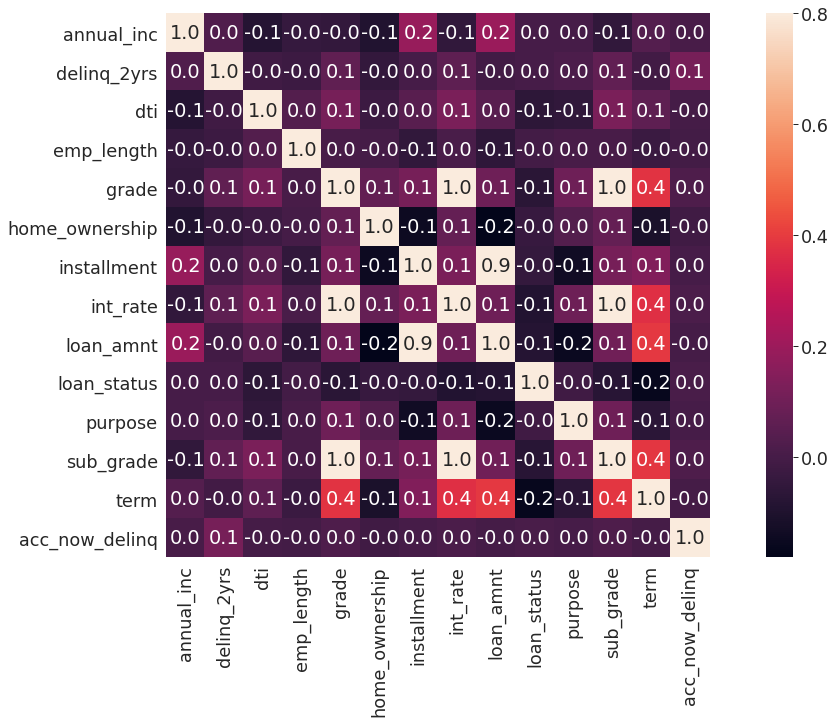

In [ ]:
plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=2)
sns.heatmap(df_exp.corr(), vmax=.8, square=True, annot=True, fmt='.1f')


## Summary

    sub_grade and term seem they have high correlation.
    Many factors(grade,loan_amnt,and int_rate seem they also have high correlation with term.
    It does not seem like loan_status is correlated to other factors

